In [6]:
import numpy as np
import numpy as np

from optyx.channel import *

In [7]:
Ket_0 = Ket(0)
Ket_1 = Ket(1)

Ket_plus = Ket("+")
Ket_minus = Ket("-")

Bra_0 = Bra(0)
Bra_1 = Bra(1)

Bra_plus = Bra("+")
Bra_minus = Bra("-")

Bit_0 = Bra(0, dom=bit)
Bit_1 = Bra(1, dom=bit)

cnot = zx.Z(1,2) @ zx.Id(1) >> zx.Id(1) @ zx.X(2,1) @ zx.Scalar(np.sqrt(2))
notc = zx.X(1,2) @ zx.Id(1) >> zx.Id(1) @ zx.Z(2,1) @ zx.Scalar(np.sqrt(2))

CNOT = Channel('CNOT', cnot)
NOTC = Channel('NOTC', notc)

X = Channel("X", zx.X(1,1,0.5))
Z = Channel("Z", zx.Z(1,1,0.5))
H = Channel("H", zx.H)

### Encoder for the [4,1,2] code

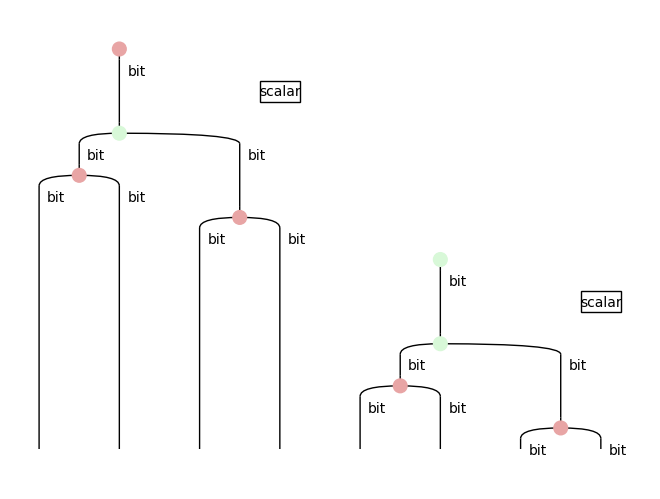

In [8]:
encoder = zx.Z(1, 2) >> zx.X(1, 2) @ zx.X(1, 2)

# Defining the logical |0> and <0|
logical_0 = zx.X(0,1) @ zx.Scalar(1/np.sqrt(2)) >> encoder
logical_0_measurement = logical_0.dagger()

Logical_0 = Channel('|0>', logical_0)
Logical_0_measurement = Channel('<0|', logical_0_measurement)

# Defining the logical |+> and <+|
logical_plus = zx.Z(0,1) @ zx.Scalar(1/np.sqrt(2)) >> encoder
logical_plus_measurement = logical_0.dagger()

Logical_plus = Channel('|+>', logical_plus)
Logical_plus_measurement = Channel('<+|', logical_plus_measurement)

(logical_0 @ logical_plus).draw()

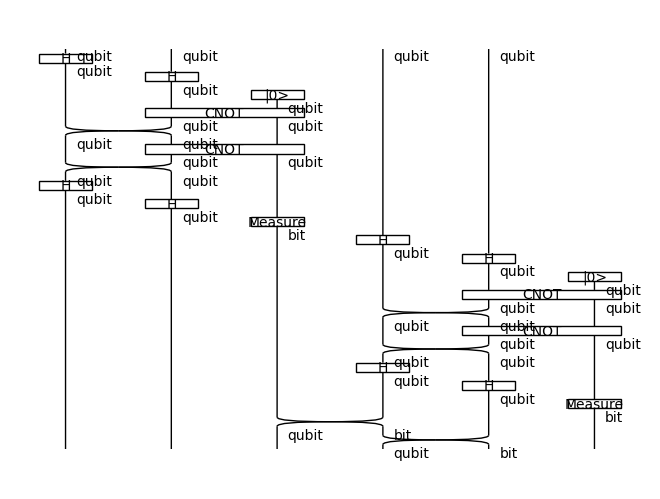

In [12]:
X_module = Circuit.id(qubit) @ CNOT >> Circuit.permutation([1, 0, 2], qubit ** 3) >> Circuit.id(qubit) @ CNOT >> Circuit.permutation([1, 0, 2], qubit ** 3)
X_parity_check = Circuit.id(qubit ** 2) @ Ket_0 >> X_module >> Circuit.id(qubit ** 2) @ Measure(qubit)
Z_parity_check = H @ H @ Ket_0 >> X_module >> H @ H @ Measure(qubit)

X_detector = X_parity_check @ X_parity_check >> Circuit.permutation([0,1,3,4,2,5], qubit ** 2 @ bit @ qubit ** 2 @ bit)
Z_detector = Z_parity_check @ Z_parity_check >> Circuit.permutation([0,1,3,4,2,5], qubit ** 2 @ bit @ qubit ** 2 @ bit)

Z_detector.draw()

### Defining the circuit with probabilistic bit-flips on data qubits

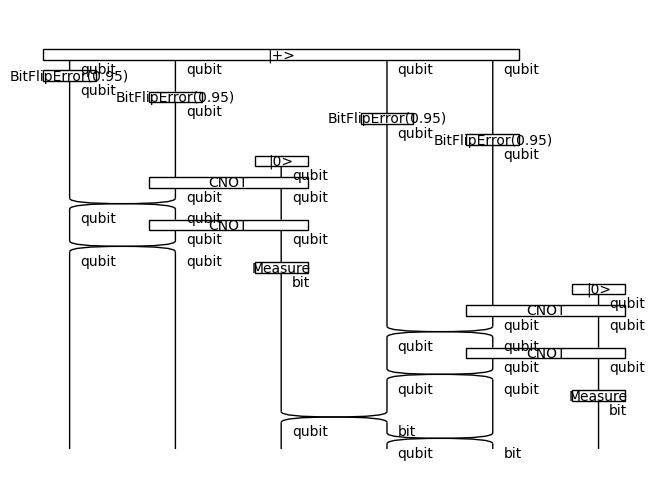

In [13]:
p_error = 0.95
Imperfect_circuit = Logical_plus >> BitFlipError(p_error) ** 4 >> X_detector

Imperfect_circuit.draw()

### Computing the fidelity after one round of X error detection

In [16]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_plus_measurement @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity:", np.sqrt(fidelity).real)

Calculated fidelity: 0.9999999999999992


## Calculating the fidelity for the distributed [4,2,2] code with an imperfect Bell state on the network

### Defining the network Bell state from its density matrix

![Density Matrix](densityMatrix.png)

The state has a fidelity of 96.89(8)% to the |Ψ+⟩ Bell state.
https://www.nature.com/articles/s41586-024-08404-x

In [ ]:
bell_density_re = np.array([
    [0.012, 0.014, 0.014, 0.000],
    [0.014, 0.508, 0.475, 0.008],
    [0.014, 0.475, 0.479, 0.009],
    [0.000, 0.008, 0.009, 0.000]
])
bell_density_im = np.exp(1j * np.pi * np.array([
    [0.000, -1.850, -1.825, -0.985],
    [1.850, 0.000, -0.002, -0.902],
    [1.825, 0.002, 0.000, -0.931],
    [0.985, 0.902, 0.931, 0.000]
]))

bell_density = np.multiply(bell_density_re, bell_density_im)
np.set_printoptions(precision=3)
print(bell_density)

In [ ]:
from discopy import tensor

bell = optyx.Box(name="Bell", dom=optyx.bit ** 2, cod=optyx.bit ** 2)
bell.array = bell_density
bell.determine_output_dimensions = lambda input_dims: input_dims
bell.truncation = lambda input_dims, output_dims: tensor.Box("Bell", dom=tensor.Dim(2)**2, cod=tensor.Dim(2)**2, data=bell_density)
bell = optyx.Spider(0, 2, typ=optyx.bit) >> optyx.Id(optyx.bit) @ optyx.Spider(0, 2, typ=optyx.bit) @ optyx.Id(optyx.bit) >> optyx.Diagram.permutation([0,1,3,2], optyx.bit**4) >> optyx.Id(optyx.bit ** 2) @ bell >> optyx.Diagram.permutation([0,2,1,3], optyx.bit**4)

Noisy_bell = CQMap('Physical Bell', bell, dom=Ty(), cod=qubit ** 2)

#### Verifying fidelity

In [ ]:
Perfect_Bell = Channel("Perfect Bell", optyx.Spider(0,2,typ=optyx.bit) @ optyx.Scalar(1 / np.sqrt(2)))
Perfect_Bell_Effect = Channel("Perfect Bell Effect", optyx.Id(optyx.bit) @ zx.X(1,1,0.5) >> optyx.Spider(2,0,typ=optyx.bit) @ optyx.Scalar(1 / np.sqrt(2)))

print("Calculated fidelity:", (Noisy_bell >> Perfect_Bell_Effect).double().to_tensor().eval().array.real)

### Defining the circuit for the distributed physical implementation

In [ ]:
cnot = zx.Id(1) @ zx.X(1,2) >> zx.Z(2,1) @ zx.Id(1)
left_module = zx.Id(1) @ cnot >> optyx.Diagram.permutation([1, 0, 2], optyx.bit ** 3) >> zx.Id(1) @ cnot >> optyx.Diagram.permutation([1, 0, 2], optyx.bit ** 3)

notc = zx.X(1,2) @ zx.Id(1) >> zx.Id(1) @ zx.Z(2,1)
right_module = notc @ zx.Id(1) >> optyx.Diagram.permutation([0, 2, 1], optyx.bit ** 3) >> notc @ zx.Id(1) >> optyx.Diagram.permutation([0, 2, 1], optyx.bit ** 3)

X = Channel("X", zx.X(1,1,0.5))
Z = Channel("Z", zx.Z(1,1,0.5))
H = Channel("H", zx.H)
Left_X_module = Channel("Left X Module", left_module, dom=qubit ** 3, cod=qubit ** 2 @ bit)
Right_X_module = Channel("Right X Module", right_module, dom=qubit ** 3, cod=bit @ qubit ** 2)

Left_Z_module = Channel(
    "Left Z Module", diag_pow(zx.H, 2) @ zx.Id(1) >> left_module >> diag_pow(zx.H, 2) @ zx.Id(1),
    dom=qubit ** 3, cod=qubit ** 2 @ bit)
Right_Z_module = Channel(
    "Right Z Module", zx.Id(1) @ diag_pow(zx.H, 2) >> right_module >> zx.Id(1) @ diag_pow(zx.H, 2),
    dom=qubit ** 3, cod=bit @ qubit ** 2)

ClassicalDetector = Channel("+", zx.X(2,1,0), dom=bit**2, cod=bit)
ClassicalCopy = Channel("copy", zx.X(2,1,0), dom=bit**2, cod=bit)

Physical_X_detector = Circuit.id(qubit ** 2) @ (Noisy_bell >> Circuit.id(qubit) @ X >> H @ H) @ Circuit.id(qubit ** 2) >> Left_X_module @ Right_X_module >> Circuit.id(qubit ** 2) @ ClassicalDetector @ Circuit.id(qubit ** 2) >> Circuit.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)

Physical_Z_detector = Circuit.id(qubit ** 2) @ (Noisy_bell >> Circuit.id(qubit) @ X >> H @ H) @ Circuit.id(qubit ** 2) >> Left_Z_module @ Right_Z_module >> Circuit.id(qubit ** 2) @ ClassicalDetector @ Circuit.id(qubit ** 2) >> Circuit.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)

Physical_X_detector.draw()

### Calculating fidelity for Z error detection

In [ ]:
Imperfect_circuit = Logical_bell >> diag_pow(DephasingError(p_error), 4) >> Physical_Z_detector
Imperfect_circuit.draw()

In [ ]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity for Z error detection:", np.sqrt(fidelity.real))

### Calculating fidelity for a whole round of Z and X error detection

In [ ]:
Imperfect_circuit = Logical_bell >> diag_pow(DephasingError(p_error), 4) >> Physical_Z_detector >> diag_pow(BitFlipError(p_error), 4) @ Circuit.id(bit) >> Physical_X_detector @ Circuit.id(bit)

P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", np.sqrt(fidelity.real))

In [ ]:
Imperfect_circuit = Logical_bell >> diag_pow(DephasingError(p_error), 4) >> Physical_Z_detector
Imperfect_circuit.draw()

## Two-qubit bit-flip with a two-qubit phase-flip repetition code

In [ ]:
Left_Z_detector = Circuit.id(qubit ** 2) @ Ket_0 >> Left_Z_module

Logical_ket_0 = Channel("|0>", zx.Z(0,2) @ optyx.Scalar(1 / np.sqrt(2)))
Logical_bra_0 = Channel("<0|", zx.Z(2,0) @ optyx.Scalar(1 / np.sqrt(2)))

Imperfect_circuit = Logical_ket_0 >> DephasingError(p_error) @ DephasingError(p_error) >> Left_Z_detector
Imperfect_circuit.draw()

In [ ]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 2) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bra_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", fidelity.real)

In [ ]:
Z_repetition_detector = Left_Z_detector @ Left_Z_detector >> Circuit.permutation([0,1,3,4,2,5], qubit ** 2 @ bit @ qubit ** 2 @ bit)
X_repetition_detector = Physical_X_detector

Imperfect_circuit = Logical_ket_0 @ Logical_ket_0 >> diag_pow(DephasingError(p_error), 4) >> Z_repetition_detector
Imperfect_circuit.draw()

In [ ]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bra_0 @ Logical_bra_0 @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", fidelity.real)

In [ ]:
Imperfect_circuit = Logical_ket_00 >> diag_pow(DephasingError(p_error), 4) >> Z_repetition_detector >> diag_pow(BitFlipError(p_error), 4) @ Circuit.id(bit ** 2) >> Physical_X_detector @ Circuit.id(bit ** 2)
# Imperfect_circuit = Logical_ket_00 >> diag_pow(DephasingError(p_error), 4) >> Z_repetition_detector
logical_ket_00 = zx.Z(0, 4)
Logical_ket_00 = Channel('|0>|0>', logical_ket_00)

logical_bra_00 = zx.Z(4, 0)
Logical_bra_00 = Channel('<0|<0|', logical_bra_00)

P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0 @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bra_00 @ Bit_0 @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", fidelity.real)
Imperfect_circuit.draw()

In [ ]:
dagger = lambda channel: Channel(name = channel.name + ".dagger()",
                                 kraus = channel.kraus.dagger(),
                                 dom= channel.cod,
                                 cod= channel.dom)

def fidelity(input_state, p_error=0.95, n_rounds=1):
    Imperfect_circuit = input_state >> diag_pow(DephasingError(p_error), 4) >> Z_repetition_detector >> diag_pow(BitFlipError(p_error), 4) @ Circuit.id(bit ** 2) >> Physical_X_detector @ Circuit.id(bit ** 2)
    P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0 @ Bit_0 @ Bit_0
    p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array
    P_00_and_s_eq_0 = Imperfect_circuit >> dagger(input_state) @ Bit_0 @ Bit_0 @ Bit_0
    p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array
    fidelity = p_00_and_s_eq_0 / p_s_eq_0
    return fidelity.real

fidelity(Logical_ket_00, 0.95, 2)

In [ ]:
xs = np.linspace(0.9, 1, 20)
ys = [fidelity(Logical_ket_00, error) for error in xs]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)
plt.plot(xs, xs)

plt.title("Fidelities after error detection")
plt.xlabel("Physical fidelity")
plt.ylabel("Logical fidelity")
plt.show()

In [ ]:
xs = np.linspace(0.99, 1, 10)
ys = [fidelity(Logical_ket_00, error) for error in xs]

In [ ]:
plt.plot(xs, ys)
plt.plot(xs, xs)

plt.title("Fidelities after error detection")
plt.xlabel("Physical fidelity")
plt.ylabel("Logical fidelity")
plt.show()

In [ ]:
(diag_pow(Ket_plus, 4) >> Physical_X_detector >> diag_pow(H, 4)).double().to_tensor().eval().array

In [ ]:
(diag_pow(Ket_plus, 4) >> Physical_X_detector ).draw()

In [ ]:
Left_X_module.double().draw()

In [ ]:
Physical_X_detector = Circuit.id(qubit ** 2) @ (Perfect_Bell >> H @ H) @ Circuit.id(qubit ** 2) >> Left_X_module @ Right_X_module >> Circuit.id(qubit ** 2) @ Discard(bit ** 2) @ Circuit.id(qubit ** 2)
Physical_X_detector.double().draw()